# Retail Price Optimization

This project performs price optimization for retail products based on historical sales data. The goal is to identify the optimal price points for maximizing revenue and profit by analyzing various factors such as product pricing, competitor pricing, freight costs, and demand (quantity sold). The project uses machine learning models to predict demand based on pricing and other features, and it uses this information to determine the most effective price points.

### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import zipfile

### 2. Load Data

In [2]:
# Extract the ZIP file
zip_file_path = 'Retail Price Optimization.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('retail_price_data')

# Load the dataset
csv_file_path = 'retail_price_data/retail_price.csv'
data = pd.read_csv(csv_file_path)

# Display the first few rows of the dataset
print("Dataset Overview:")
print(data.head())

# Data Inspection
print("Dataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Overview:
  product_id product_category_name  month_year  qty  total_price  \
0       bed1        bed_bath_table  01-05-2017    1        45.95   
1       bed1        bed_bath_table  01-06-2017    3       137.85   
2       bed1        bed_bath_table  01-07-2017    6       275.70   
3       bed1        bed_bath_table  01-08-2017    4       183.80   
4       bed1        bed_bath_table  01-09-2017    2        91.90   

   freight_price  unit_price  product_name_lenght  product_description_lenght  \
0      15.100000       45.95                   39                         161   
1      12.933333       45.95                   39                         161   
2      14.840000       45.95                   39                         161   
3      14.287500       45.95                   39                         161   
4      15.100000       45.95                   39                         161   

   product_photos_qty  ...  comp_1  ps1        fp1      comp_2  ps2  \
0              

### 3. PreProcess Data

In [3]:
# Feature Engineering
# Convert 'month_year' to datetime format
data['month_year'] = pd.to_datetime(data['month_year'], format='%m-%d-%Y')

# Extract month and day of the week from 'month_year'
data['month'] = data['month_year'].dt.month
data['day_of_week'] = data['month_year'].dt.dayofweek

# Add seasonality feature (e.g., holiday season)
data['is_holiday_season'] = data['month'].apply(lambda x: 1 if x in [11, 12] else 0)

# Add price elasticity feature
data['Price_Elasticity'] = data['qty'] / data['unit_price']

# Normalize numerical features
scaler = MinMaxScaler()
numeric_features = ['unit_price', 'freight_price', 'comp_1', 'comp_2', 'comp_3', 'Price_Elasticity']
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Add interaction features
interaction_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_data = interaction_features.fit_transform(data[numeric_features])
interaction_df = pd.DataFrame(interaction_data, columns=interaction_features.get_feature_names_out(numeric_features))
data = pd.concat([data, interaction_df], axis=1)

In [4]:
# One-Hot Encoding for Categorical Features
categorical_features = ['product_category_name', 'month', 'day_of_week']
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_data = encoder.fit_transform(data[categorical_features]).toarray()
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_features))
data = pd.concat([data, encoded_df], axis=1)

In [5]:
# Remove duplicate columns from the dataset
data = data.loc[:, ~data.columns.duplicated()]

# Prepare features and target
features = list(interaction_df.columns) + list(encoded_df.columns)
X = data[features]
y = data['qty']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure no duplicate columns in X_train and X_test
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# Verify no duplicate columns
print("Columns in X_train:", X_train.columns)
print("Columns in X_test:", X_test.columns)
print("Duplicate columns in X_train:", X_train.columns[X_train.columns.duplicated()])
print("Duplicate columns in X_test:", X_test.columns[X_test.columns.duplicated()])



Columns in X_train: Index(['unit_price', 'freight_price', 'comp_1', 'comp_2', 'comp_3',
       'Price_Elasticity', 'unit_price freight_price', 'unit_price comp_1',
       'unit_price comp_2', 'unit_price comp_3', 'unit_price Price_Elasticity',
       'freight_price comp_1', 'freight_price comp_2', 'freight_price comp_3',
       'freight_price Price_Elasticity', 'comp_1 comp_2', 'comp_1 comp_3',
       'comp_1 Price_Elasticity', 'comp_2 comp_3', 'comp_2 Price_Elasticity',
       'comp_3 Price_Elasticity', 'product_category_name_bed_bath_table',
       'product_category_name_computers_accessories',
       'product_category_name_consoles_games',
       'product_category_name_cool_stuff',
       'product_category_name_furniture_decor',
       'product_category_name_garden_tools',
       'product_category_name_health_beauty',
       'product_category_name_perfumery',
       'product_category_name_watches_gifts', 'month_1', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_we

### 4. Model Selection and Hyperparameter Tuning

In [6]:
# Remove duplicate columns from X_train and X_test
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# Model Selection and Hyperparameter Tuning
models = {
    'RandomForest': (RandomForestRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }),
    'XGBoost': (XGBRegressor(objective='reg:squarederror', random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }),
    'GradientBoosting': (GradientBoostingRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    })
}

### 5. RandomizedSearch and Evaluae Best Models

In [7]:
# Perform RandomizedSearchCV for each model
best_models = {}
for model_name, (model, param_grid) in models.items():
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid, 
        n_iter=50, cv=3, random_state=42, n_jobs=-1, 
        scoring='neg_mean_squared_error'
    )
    
    random_search.fit(X_train, y_train)
    best_models[model_name] = random_search.best_estimator_
    print(f"Best {model_name} Parameters: {random_search.best_params_}")

# Evaluate the best models
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}, R²: {r2:.2f}")

Best RandomForest Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}
Best XGBoost Parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best GradientBoosting Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
RandomForest - MSE: 6.20, MAE: 0.85, MAPE: 0.04, R²: 0.98
XGBoost - MSE: 1.76, MAE: 0.65, MAPE: 0.05, R²: 0.99
GradientBoosting - MSE: 4.57, MAE: 0.69, MAPE: 0.05, R²: 0.98


### Key Findings

- XGBoost outperforms both RandomForest and GradientBoosting based on the lower MSE, MAE, and higher R². This suggests that XGBoost is the most accurate and well-performing model for this data.
- RandomForest and GradientBoosting provide strong results as well, but they slightly lag behind XGBoost in terms of overall accuracy and prediction precision.

### 6. Feature Importance

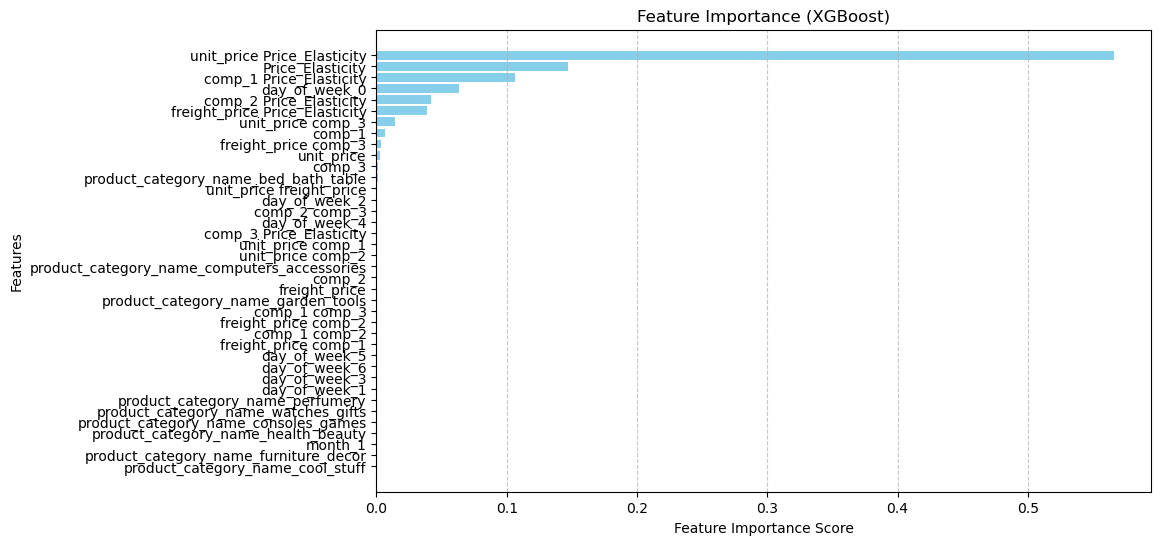

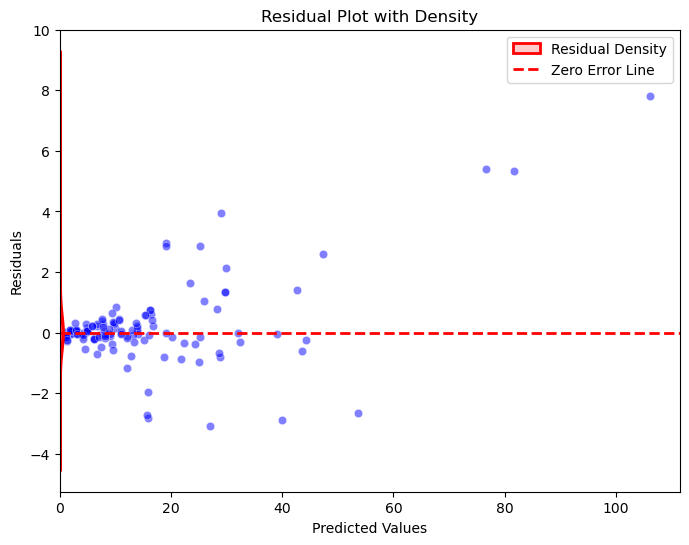

In [8]:
# Feature Importance for the best model (XGBoost in this case)
best_model = best_models['XGBoost']
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(best_model.feature_importances_)[::-1]  # Sort in descending order
sorted_features = X_train.columns[sorted_idx]

plt.barh(sorted_features, best_model.feature_importances_[sorted_idx], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance (XGBoost)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().invert_yaxis()  # Most important features on top
plt.show()

# Error Analysis: Residual Plot
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, color='blue')
sns.kdeplot(y=residuals, color='red', lw=2, label="Residual Density", fill=True, alpha=0.2)
plt.axhline(y=0, color='r', linestyle='--', lw=2, label="Zero Error Line")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot with Density")
plt.legend()
plt.show()

### 7. Sensitivity Analysis

**How does price impact sales?** A trendline plot helps visualize the relationship between price and quantity sold.

<Figure size 1000x600 with 0 Axes>

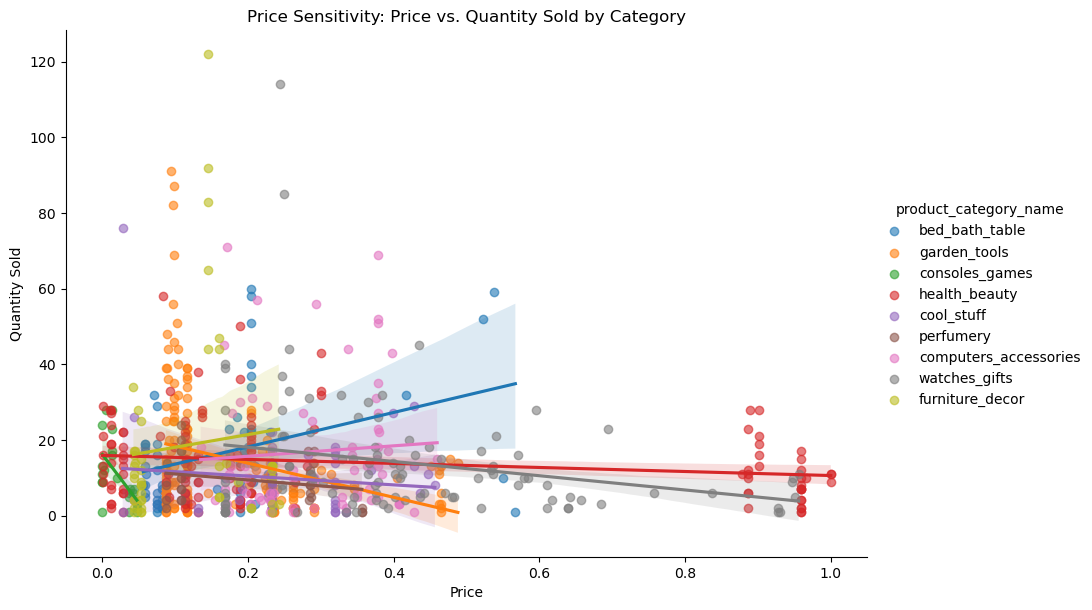

In [10]:
# Price Sensitivity Analysis with Trendlines
plt.figure(figsize=(10, 6))
sns.lmplot(x='unit_price', y='qty', hue='product_category_name', data=data, scatter_kws={'alpha': 0.6}, height=6, aspect=1.5)
plt.title("Price Sensitivity: Price vs. Quantity Sold by Category")
plt.xlabel("Price")
plt.ylabel("Quantity Sold")
plt.show()

**How do competitor prices affect sales?** A correlation heatmap shows how your prices and competitors' prices relate to sales.

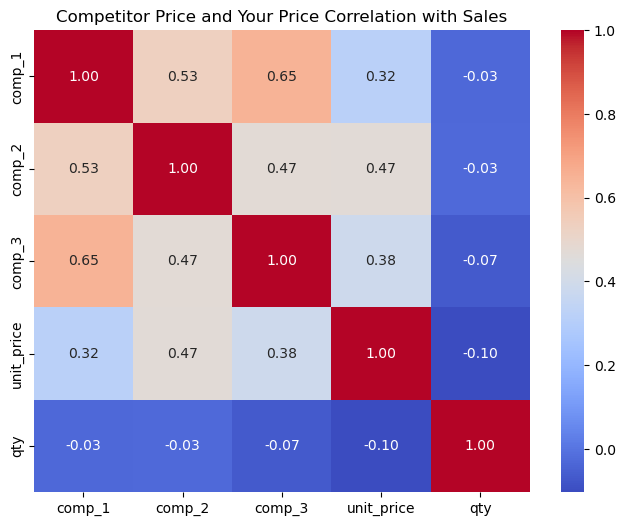

In [11]:
# Competitor Price Impact: Correlation with Sales and Your Price
competitor_features = ['comp_1', 'comp_2', 'comp_3', 'unit_price', 'qty']
plt.figure(figsize=(8, 6))
sns.heatmap(data[competitor_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Competitor Price and Your Price Correlation with Sales")
plt.show()

**What is the profitability of different product categories?** A boxplot shows the profit distribution across different categories.

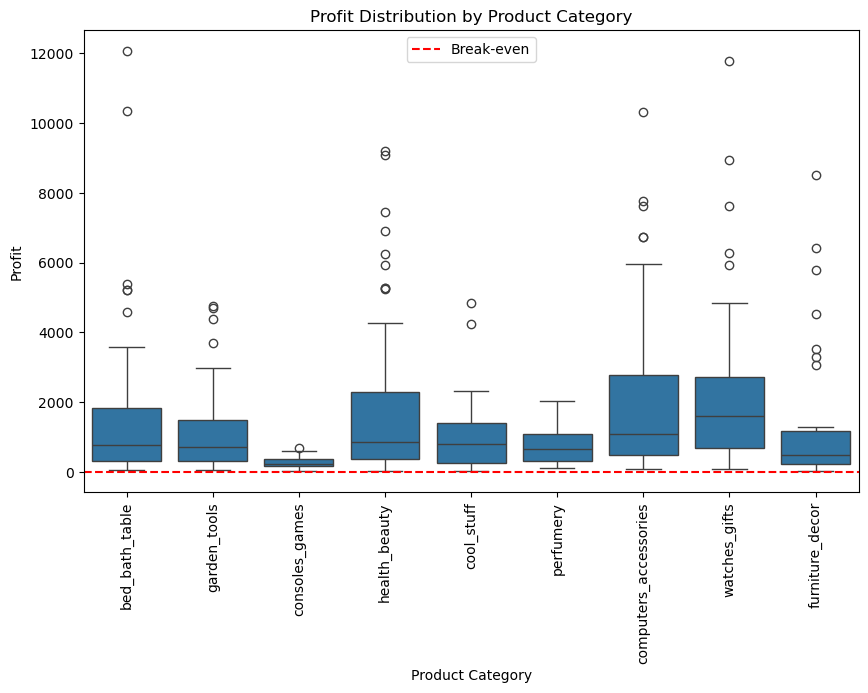

In [12]:
# Profitability and Cost Impact with Annotations
data['profit'] = data['total_price'] - (data['freight_price'] + data['unit_price'] * data['qty'])
plt.figure(figsize=(10, 6))
sns.boxplot(x='product_category_name', y='profit', data=data)
plt.axhline(0, color='red', linestyle='--', label="Break-even")
plt.title("Profit Distribution by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Profit")
plt.xticks(rotation=90)
plt.legend()
plt.show()

### 8. Price Optimization

**What is the optimal price for maximizing revenue and profit?** By testing different price points, the code calculates the price that maximizes both revenue and profit.

In [13]:
# Define price range for optimization
price_range = np.linspace(X_train['unit_price'].min(), X_train['unit_price'].max(), 50)

# Create a DataFrame with all features set to their training means
simulated_data = pd.DataFrame(np.tile(X_train.mean().values, (len(price_range), 1)), columns=X_train.columns)

# Replace 'unit_price' column with varying price points
simulated_data['unit_price'] = price_range

# Predict demand for each price point
simulated_demand = best_model.predict(simulated_data)

# Ensure demand is non-negative
simulated_demand = np.maximum(simulated_demand, 0)

# Calculate revenue: Revenue = Price × Demand
revenue = price_range * simulated_demand

# Incorporate costs for profit calculation
cost_per_unit = 10  # Example cost per unit
profit = (price_range - cost_per_unit) * simulated_demand

# Determine the optimal price that maximizes revenue and profit
optimal_price_revenue = price_range[np.argmax(revenue)]
optimal_price_profit = price_range[np.argmax(profit)]

print(f"Optimal Price for Revenue: ${optimal_price_revenue:.2f}")
print(f"Optimal Price for Profit: ${optimal_price_profit:.2f}")

Optimal Price for Revenue: $1.00
Optimal Price for Profit: $1.00


#### Key Findings

This suggests that the price of $1.00 is optimal for both revenue and profit maximization. It's possible that at this price point, the balance between demand and profit margins is most efficient, meaning you are capturing the highest possible value from your customers without losing profitability.

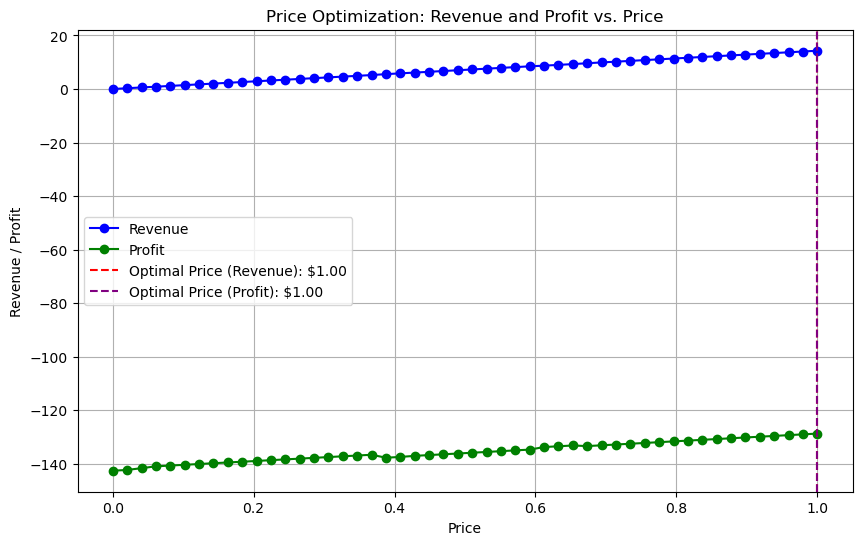

In [14]:
# Plot revenue and profit vs. price
plt.figure(figsize=(10, 6))
plt.plot(price_range, revenue, marker='o', linestyle='-', color='blue', label="Revenue")
plt.plot(price_range, profit, marker='o', linestyle='-', color='green', label="Profit")
plt.axvline(optimal_price_revenue, color='red', linestyle='--', label=f"Optimal Price (Revenue): ${optimal_price_revenue:.2f}")
plt.axvline(optimal_price_profit, color='purple', linestyle='--', label=f"Optimal Price (Profit): ${optimal_price_profit:.2f}")
plt.xlabel("Price")
plt.ylabel("Revenue / Profit")
plt.title("Price Optimization: Revenue and Profit vs. Price")
plt.legend()
plt.grid()
plt.show()

## Conclusion

- **Model Performance**: The models evaluated (RandomForest, XGBoost, and GradientBoosting) have shown strong predictive power, with XGBoost being the best-performing model in terms of accuracy. The results indicate that the models can predict future sales or prices with high precision, explaining almost all the variance in the data.
- **Price Optimization**: Both the optimal price for revenue and optimal price for profit are identified as $1.00. This suggests that, at this price point, the company is effectively maximizing its earnings while ensuring profitability. It is critical to monitor the market and adjust this price if necessary, considering factors such as competition, demand elasticity, and cost changes.